## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [32]:
import glob

import numpy as np
import scipy as sp
import scipy.signal
import scipy.io


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def LowpassFilter(signal, fs):
    b, a = sp.signal.butter(3, 12, btype='lowpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def BandpassFilter(signal, fs=125):
    """
    Bandpass filter the signal between 70 and 190 BPM.
    """
    b, a = sp.signal.butter(3, (70/60, 190/60), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def fft(sig, fs):
    freqs = np.fft.rfftfreq(len(sig), 1/fs)
    fft_mag = np.abs(np.fft.rfft(sig))
    return (freqs, fft_mag)

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()

    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
    # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def GetData():
    data_fls, ref_fls = LoadTroikaDataset()
    ppg_list, accx_list, accy_list, accz_list = [], [], [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
        ppg_list.append(ppg)
        accx_list.append(accx)
        accy_list.append(accy)
        accz_list.append(accz)
    ppg_list = np.hstack(ppg_list)
    accx_list = np.hstack(accx_list)
    accy_list = np.hstack(accy_list)
    accz_list = np.hstack(accz_list)
    return ppg_list, accx_list, accy_list, accz_list

def RunPulseRateAlgorithm(data_fl, ref_fl):
    fs = 125
    # Ground Truth
    ref_hrs = sp.io.loadmat(ref_fl)['BPM0']
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    acc = np.mean([accx, accy, accz], axis=0)
    data_list = [ppg, acc]
    label_list = ['ppg', 'acc']

    # Bandpass filter the signal between 70 and 190 BPM
    filtered = {label: BandpassFilter(data, fs) for (
        label, data) in zip(label_list, data_list)}   
    
    # Compute pulse rate estimates and estimation confidence.
    # Move with a window_length_s of 8s and the window_shift_s of 2s
    # The ground truth data follows the same cadence
    errors, confidence = [], []
    window_length_s = 8
    window_shift_s = 2
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs
    idx = list(range(0, len(ppg) - window_length, window_shift))
    for i in idx:
        segments = {label: filtered[label][
            i: i + window_length] for label in label_list}

        freqs, mags, sorted_inds, sorted_freqs = {}, {}, {}, {}
        for label in label_list:
            freqs[label], mags[label] = fft(segments[label], fs)
            sorted_inds[label] = np.argsort(mags[label])[::-1][:4]
            sorted_freqs[label] = freqs[label][sorted_inds[label]]

        try:
            est_f = [freq for freq in sorted_freqs['ppg']
                     if freq not in sorted_freqs['acc']][0]

        except:
            ind = sorted_inds['ppg'][0]
            est_f = freqs['ppg'][ind]

        est_hr = est_f * 60
        ref_hr = ref_hrs[idx.index(i)][0]
        errors.append(np.mean(np.abs(est_hr-ref_hr)))
        confidence.append(np.sum(mags['ppg'][(freqs['ppg'] >= est_f-30/60) & (
                    freqs['ppg'] <= est_f+30/60)]) / np.sum(mags['ppg']))
    return np.array(errors), np.array(confidence)

In [33]:
Evaluate()

15.524581670768509

In [34]:
ppg_list, accx_list, accy_list, accz_list = GetData()

In [35]:
ppg_list, accx_list, accy_list, accz_list

(array([  4. ,   6. ,   3. , ...,  -3. , -11. , -22.5]),
 array([-0.0702, -0.0702, -0.0546, ..., -0.1326, -0.1326, -0.1248]),
 array([ 0.3432,  0.3588,  0.3666, ...,  0.624 ,  0.624 ,  0.624 ]),
 array([ 0.9594,  0.9438,  0.936 , ...,  0.6318,  0.6084,  0.624 ]))

In [36]:
import matplotlib.pyplot as plt

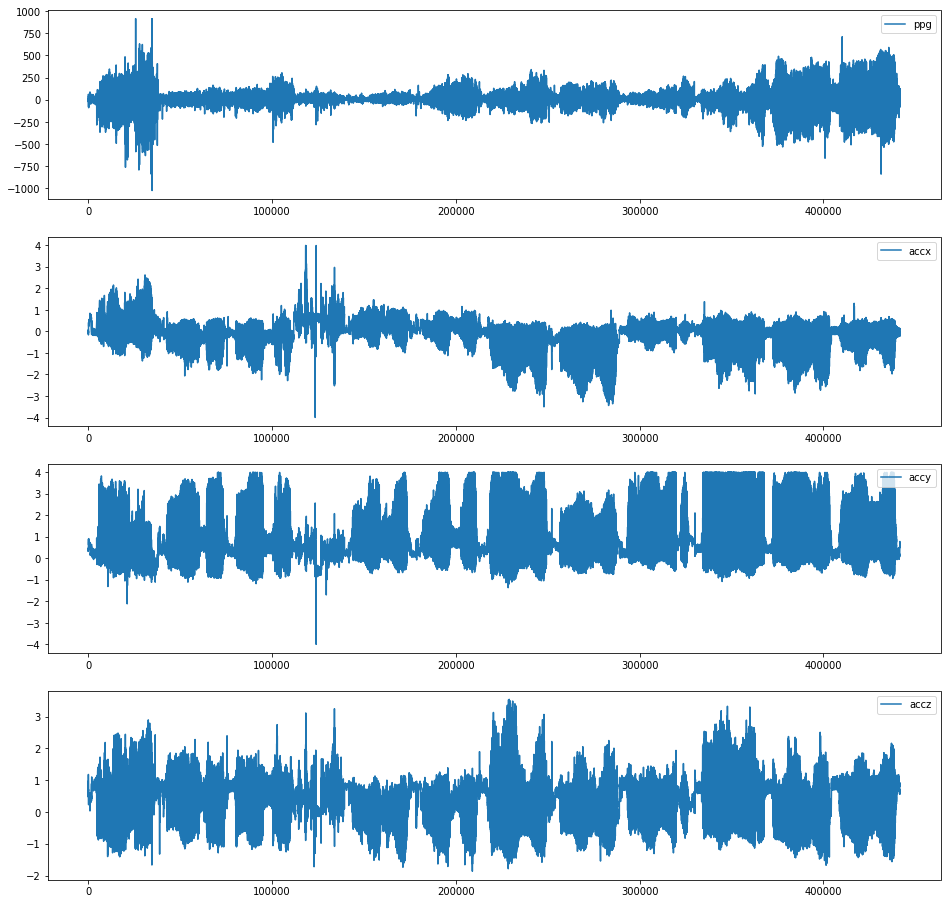

In [37]:
data_list = [ppg_list, accx_list, accy_list, accz_list]
label_list = ['ppg', 'accx', 'accy', 'accz']

figs, axes = plt.subplots(4, figsize=(16, 16))
for i, ax in enumerate(axes):
    axes[i].plot(data_list[i], label = label_list[i])
    axes[i].legend(loc='upper right')

In [38]:
data_list

[array([  4. ,   6. ,   3. , ...,  -3. , -11. , -22.5]),
 array([-0.0702, -0.0702, -0.0546, ..., -0.1326, -0.1326, -0.1248]),
 array([ 0.3432,  0.3588,  0.3666, ...,  0.624 ,  0.624 ,  0.624 ]),
 array([ 0.9594,  0.9438,  0.936 , ...,  0.6318,  0.6084,  0.624 ])]

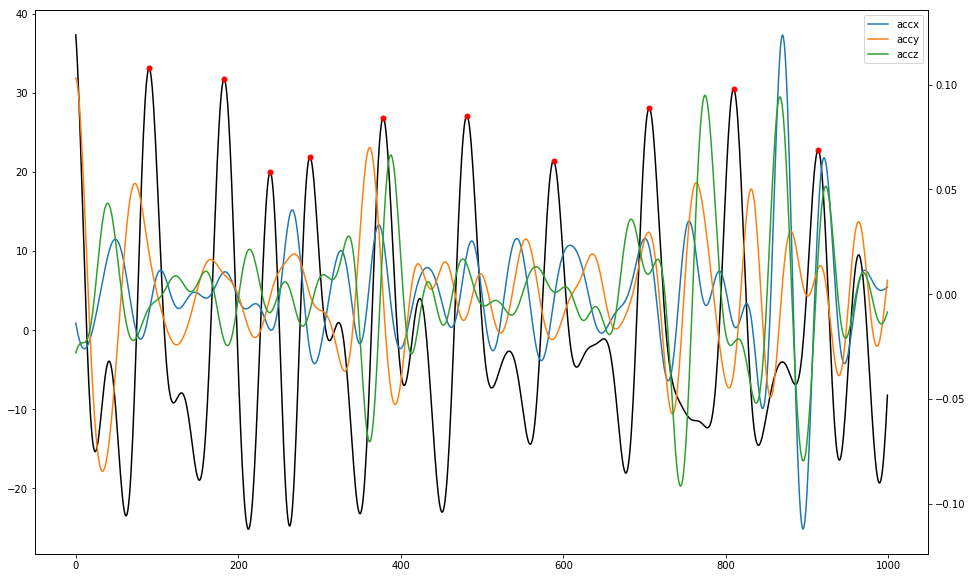

In [39]:
fs = 125
filtered = {label : BandpassFilter(data) for (label, data) in zip(label_list, data_list)}
ppg_seg = filtered['ppg'][1000:2000]
pks = sp.signal.find_peaks(ppg_seg, height=15, distance=35)[0]

fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()

ax1.plot(ppg_seg, 'black')
ax1.plot(pks, ppg_seg[pks], 'r.', ms=10)

for label in label_list[1:]:
    ax2.plot(filtered[label][1000:2000], label=label)
    ax2.legend(loc='upper right')

plt.show()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

**Code Description**

To retrieve the pulse rate error metrics, one can run the Evaluate() function.

**Data Description** 

The data comes from Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. (https://ieeexplore.ieee.org/document/6905737)

From the abstract - "The TROIKA framework has high estimation accuracy and is robust to strong motion artifacts. Many variants can be straightforwardly derived from this framework. Experimental results on datasets recorded from 12 subjects during fast running at the peak speed of 15 km/h showed that the average absolute error of heart rate estimation was 2.34 beat per minute, and the Pearson correlation between the estimates and the ground truth of heart rate was 0.992. This framework is of great values to wearable devices such as smartwatches which use PPG signals to monitor heart rate for fitness."

One short-coming of this dataset is that it is very controlled in that it is recordings during fast running. To be more reliable in a real-world scenario, the model should use a dataset that includes all activity types including resting.

**Algorithhm Description**

The algorithm works by computing pulse rate estimates and estimation confidences with a window length of 8 seconds and window shift of 2 seconds. It uses a bandpass filter to filter the signal between 70 and 190 beats per minute. It then runs a Fast Fourier Transform to transform the signal. Last, the Mean Absolute Error is computed and aggregated across all trials to be returned as the final result of the Evaluate() function. 

One **caveat** on the algorithm output is that the signal could be generated by arm motion in addition to pulse. This could lead to a **common failure mode** of the arm swing being measured as the pulse rate.

**Algorithm Performance** 

The tradeoff of MAE vs. Availability should be considered when evaluating the performance of this algorithm. Utilizing 100% of the data leads to a higher MAE because some data will not be the best estimates based off the confidence intervals. I used 90% availability and returned a MAE of 15.5 BPM.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 